In [ ]:
import matplotlib.pyplot as plt
import numpy as np, torch, dill, time, os
from Ctubes.geometry_utils import regular_polygon
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import get_pairings_all, load_curve_from_obj
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Figure 16: Bridge – Alignment Constraints

## #1: Directrix Self-Distance

In [137]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig16_bridge_directrix_dist")

In [138]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig16_bridge/directrix_Q.obj"))
K = cps_ref.shape[0]
M = (K - 1) * 8 + 1

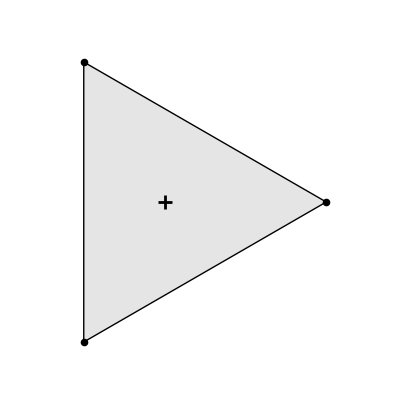

In [139]:
# Generatrix: regular N-gon
N = 3
tube_radius = 1.5
generatrix_2d = regular_polygon(N, tube_radius)

fig, ax = plot_generatrix(generatrix_2d)

In [140]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
theta = torch.tensor(PI/2)
generatrix = Generatrix(generatrix_2d, X0, T0, theta)

tube = CTube(directrix, generatrix, plane_normal_kind='bisecting')

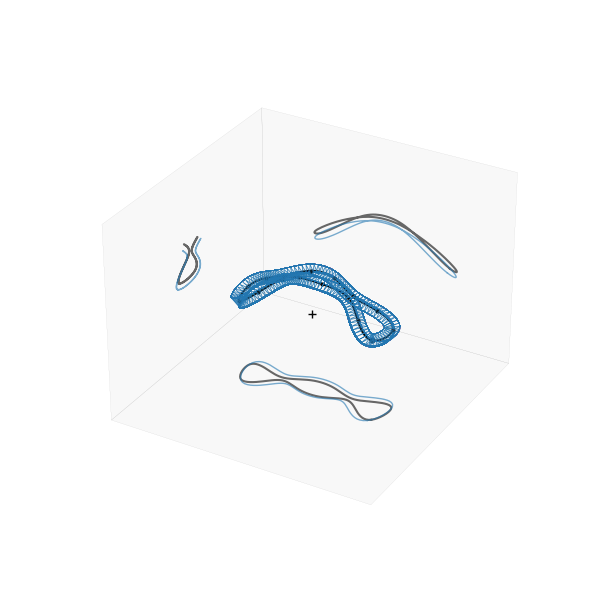

In [141]:
fig, ax = tube.plot_3d()

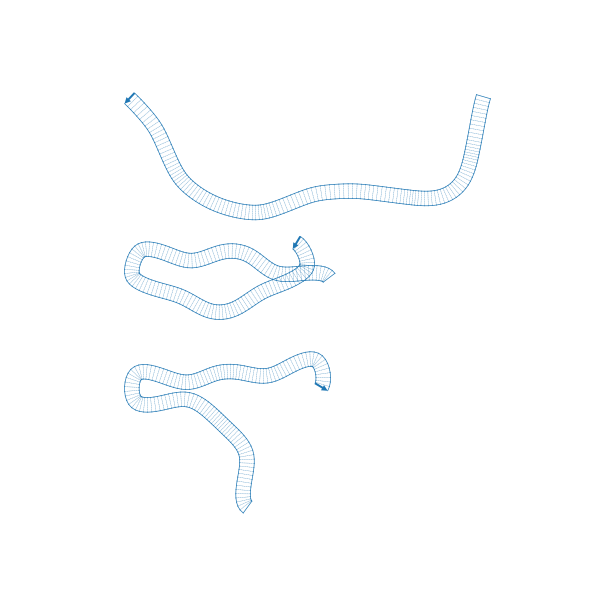

In [142]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [143]:
# Set up optimization problem

opt_weights = {
    'preserve_curve': 1e2 / directrix.aabb_diagonal_length() ** 2,
    'join_ends': 1e1 / generatrix.aabb_diagonal_length() ** 2,
    'min_directrix_self_distance': 1e2 / tube.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_all(N),
    'min_directrix_self_target_distance': 2*tube_radius,
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(True)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [144]:
# Save initial state
paths_init = setup_paths(get_name(), test_name="fig16_bridge_init")

opt_prob.save_meshes(paths=paths_init)
opt_prob.save_optimization_results(paths=paths_init)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [146]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           48     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56256D-01    |proj g|=  3.26768D-01

At iterate    1    f=  3.56164D-01    |proj g|=  3.31628D-01


 This problem is unconstrained.



At iterate    2    f=  2.38945D-01    |proj g|=  2.68600D-01

At iterate    3    f=  2.90447D-02    |proj g|=  2.01829D-02

At iterate    4    f=  2.76606D-02    |proj g|=  1.33123D-02

At iterate    5    f=  2.70172D-02    |proj g|=  1.28391D-02

At iterate    6    f=  2.62567D-02    |proj g|=  1.27865D-02

At iterate    7    f=  2.56611D-02    |proj g|=  1.09449D-02

At iterate    8    f=  2.51731D-02    |proj g|=  1.07091D-02

At iterate    9    f=  2.50661D-02    |proj g|=  1.12313D-02

At iterate   10    f=  2.49808D-02    |proj g|=  1.04986D-02

At iterate   11    f=  2.49219D-02    |proj g|=  1.20273D-02

At iterate   12    f=  2.48989D-02    |proj g|=  1.18194D-02

At iterate   13    f=  2.48809D-02    |proj g|=  1.08872D-02

At iterate   14    f=  2.47939D-02    |proj g|=  1.09128D-02

At iterate   15    f=  2.47882D-02    |proj g|=  1.04771D-02

At iterate   16    f=  2.47824D-02    |proj g|=  1.13229D-02

At iterate   17    f=  2.47792D-02    |proj g|=  1.12682D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [147]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0215112038
join_ends                               : 0.0000000350
min_directrix_self_distance             : 0.0014705639
smooth_plane_normal_diffs               : 0.0015570580
preserve_tube_ridge_edge_directions     : 0.0000182089


tensor(0.0246)

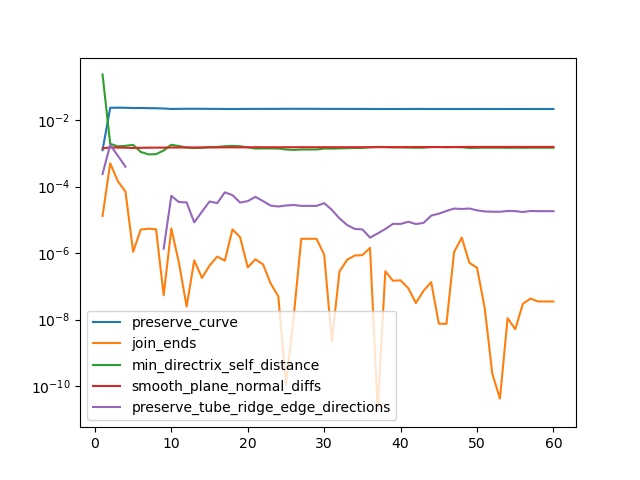

In [148]:
fig, ax = opt_prob.plot_objective_history()

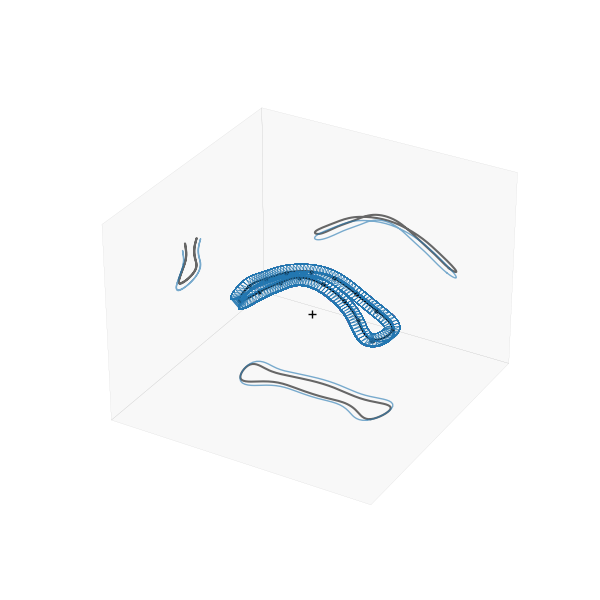

In [149]:
fig, ax = opt_prob.plot_3d()

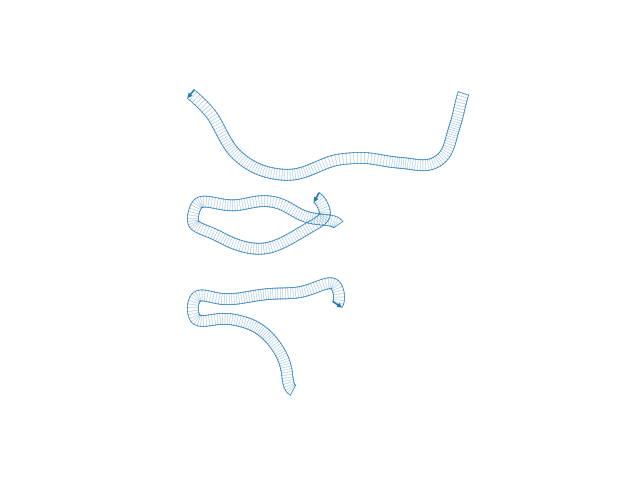

In [150]:
fig, ax = opt_prob.plot_unrolled_strips()

## #2: Quad Tangency + Quad Distance

In [151]:
# Unpickle the optimization problem
paths_load = setup_paths(get_name(), test_name="fig16_bridge_directrix_dist")
pkl_file = os.path.join(paths_load["output"], "opt/opt_prob.pkl")
opt_prob = dill.load(open(pkl_file, "rb"))
tube_net = opt_prob.tube_network
tube = tube_net.tubes[0]

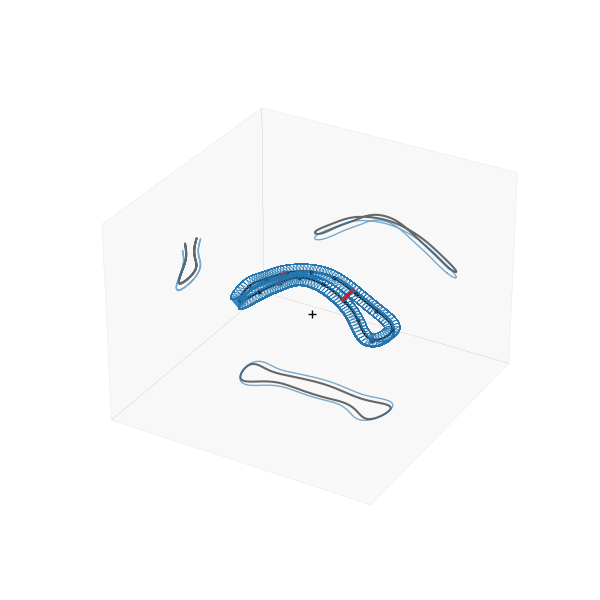

In [152]:
# Compute edge midpoints
edge_midpoints = [pts[:-1] + (pts[1:] - pts[:-1]) / 2 for pts in [tube.directrix.X]]

# Manually set point pairs
point_pairs = torch.tensor([
    [25, 111],
    [48, 87],
])

# Plot
fig, ax = tube.plot_3d()

# Plot point pairs by connecting them with a line
for i, j in point_pairs:
    ax.plot(
        [edge_midpoints[0][i, 0], edge_midpoints[0][j, 0]], 
        [edge_midpoints[0][i, 1], edge_midpoints[0][j, 1]], 
        [edge_midpoints[0][i, 2], edge_midpoints[0][j, 2]], color='r', linewidth=3
    )

plt.show()

In [153]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig16_bridge_quad_alignment")

In [154]:
# Quad pairings for tangency
quad_pairs = point_pairs  # midpoint indices correspond to quad indices
n_quad_constraints = len(quad_pairs)

quad_pair_tube_indices = torch.tensor([[0, 0] for _ in range(n_quad_constraints)], dtype=torch.int64)

quad_pair_tube_indices_any_pairing = quad_pair_tube_indices
quad_pair_disc_indices_any_pairing = quad_pairs

quad_face_dist_tube_indices = quad_pair_tube_indices
quad_face_dist_disc_indices = quad_pairs

quad_face_dist_cross_section_indices = torch.tensor([[1, 1] for _ in range(n_quad_constraints)], dtype=torch.int64)

target_dist = 0.1 * tube_radius
quad_face_dist_target_distances = torch.tensor([target_dist for _ in range(n_quad_constraints)])

### Optimization

In [155]:
# Set up optimization problem

opt_weights = {
    'preserve_curve': 1e2 / directrix.aabb_diagonal_length() ** 2,
    'join_ends': 1e0 / generatrix.aabb_diagonal_length() ** 2,
    'quad_tangency_any_pairing': 1e1,
    'quad_distance': 1e4 / directrix.aabb_diagonal_length() ** 2,
}

objective_args = {

    # Join ends
    'join_ends_pairings': get_pairings_all(N),
    
    # Quad tangency any pairing
    'quad_pair_tube_indices_any_pairing': quad_pair_tube_indices_any_pairing,
    'quad_pair_disc_indices_any_pairing': quad_pair_disc_indices_any_pairing,

    # Quad distance
    'quad_face_dist_tube_indices': quad_face_dist_tube_indices,
    'quad_face_dist_disc_indices': quad_face_dist_disc_indices,
    'quad_face_dist_cross_section_indices': quad_face_dist_cross_section_indices,
    'quad_face_dist_target_distances': quad_face_dist_target_distances,
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(True)
opt_prob.activate_theta(True)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [156]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0215704238
join_ends                               : 0.0000000035
quad_tangency_any_pairing               : 2.8310737824
quad_distance                           : 91.1694120684
smooth_plane_normal_diffs               : 0.0015570580
preserve_tube_ridge_edge_directions     : 0.0000182089


tensor(94.0236)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [158]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           49     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07323D+01    |proj g|=  9.70889D+01

At iterate    1    f=  1.15353D+01    |proj g|=  1.38201D+01

At iterate    2    f=  4.38615D+00    |proj g|=  8.84900D+00

At iterate    3    f=  1.82463D-02    |proj g|=  4.97834D-01

At iterate    4    f=  1.20017D-02    |proj g|=  1.70587D-01

At iterate    5    f=  1.10079D-02    |proj g|=  2.63409D-02

At iterate    6    f=  1.09627D-02    |proj g|=  2.43357D-02

At iterate    7    f=  1.03892D-02    |proj g|=  7.78978D-02

At iterate    8    f=  9.33002D-03    |proj g|=  1.17955D-01

At iterate    9    f=  6.90322D-03    |proj g|=  3.12735D-02

At iterate   10    f=  6.72288D-03    |proj g|=  8.53489D-02

At iterate   11    f=  6.57992D-03    |proj g|=  7.08874D-02

At iterate   12    f=  6.23042D-03    |proj g|=  7.08076D-02

At iterate   13    f=  5.8

In [159]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0028083444
join_ends                               : 0.0000001565
quad_tangency_any_pairing               : 0.0001758332
quad_distance                           : 0.0000005835
smooth_plane_normal_diffs               : 0.0014390888
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(0.0044)

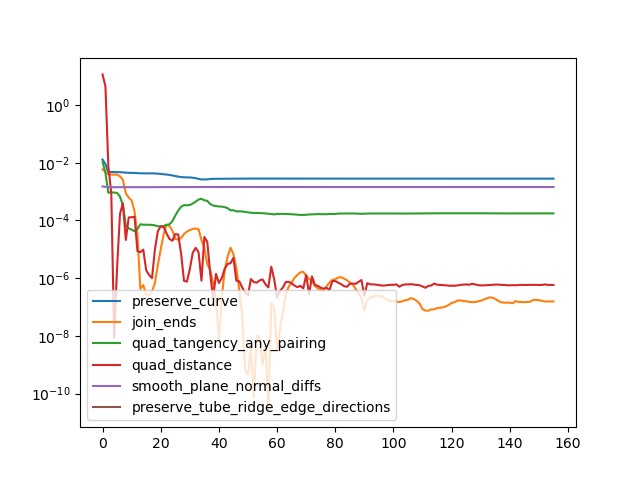

In [160]:
fig, ax = opt_prob.plot_objective_history()

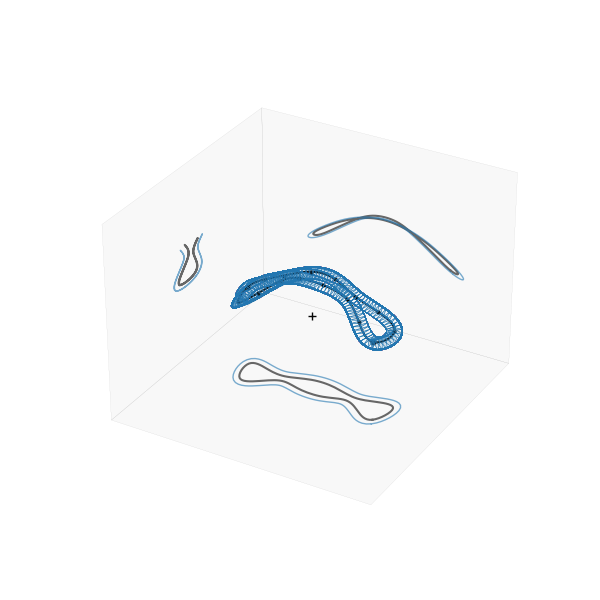

In [161]:
fig, ax = opt_prob.plot_3d()

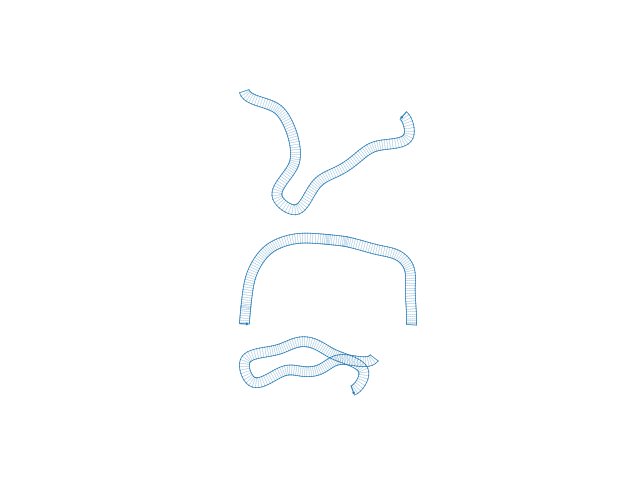

In [162]:
fig, ax = opt_prob.plot_unrolled_strips()

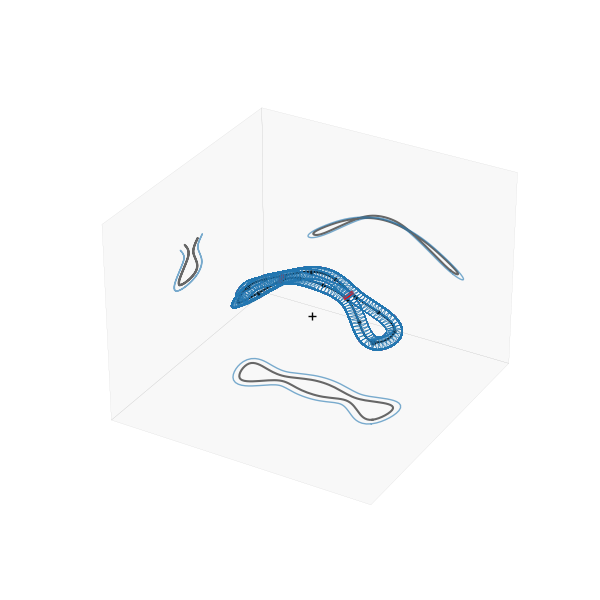

In [163]:
# Compute edge midpoints
edge_midpoints = [(pts[:-1] + (pts[1:] - pts[:-1]) / 2).detach().cpu().numpy() for pts in opt_prob.tube_network.get_polylines()]

# Plot
fig, ax = opt_prob.plot_3d()

# Plot point pairs by connecting them with a line
for i, j in point_pairs:
    ax.plot(
        [edge_midpoints[0][i, 0], edge_midpoints[0][j, 0]], 
        [edge_midpoints[0][i, 1], edge_midpoints[0][j, 1]], 
        [edge_midpoints[0][i, 2], edge_midpoints[0][j, 2]], color='r', linewidth=3
    )

plt.show()